# Preparação Dos Dados


In [2]:
import pandas as pd
import numpy as np
import os

# Leitura dos dados originais
# Mostrar todas as colunas
pd.set_option('display.max_columns', None)
file_path = 'data/TUCURUI_DIARIA_1939_2016.xlsx'
data = pd.read_excel(file_path, header=None, names=['Vazao'])

# Função para calcular derivadas percentuais


def calcular_derivadas(data):
    data['V1'] = data['Vazao'].pct_change() * 100  # Primeira derivada
    data['V2'] = data['V1'].diff()  # Segunda derivada
    return data

# Função para criar defasagens


def criar_defasagens(data, colunas, entradas):
    defasagens_list = []

    for col in colunas:
        for i in range(entradas, 0, -1):
            defasagens_list.append(data[col].shift(
                i).rename(f'Entrada_{col}_{i}'))
        defasagens_list.append(data[col])

    for i in range(1, 12):
        defasagens_list.append(data['Vazao'].shift(-i).rename(f'Saida_{i}'))
    defasagens = pd.concat(defasagens_list, axis=1)
    return defasagens


# Função para criar colunas binárias
def criar_colunas_binarias(data):
    # Inicializar as colunas binárias com zeros
    data['Bin1'] = 0
    data['Bin2'] = 0
    data['Bin3'] = 0

    # Aplicar as condições para definir os valores das colunas binárias
    data.loc[(data['V1'] > 40) & (data['V2'] > 0),
             ['Bin1', 'Bin2', 'Bin3']] = [1, 0, 0]
    data.loc[(data['V1'] < -40) & (data['V2'] < 0),
             ['Bin1', 'Bin2', 'Bin3']] = [0, 0, 1]
    data.loc[~((data['V1'] > 40) & (data['V2'] > 0)) & ~(
        (data['V1'] < -40) & (data['V2'] < 0)), ['Bin1', 'Bin2', 'Bin3']] = [0, 1, 0]

    return data

# **TREINAMENTO - MODELO 1**


In [3]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,InputLayer

data_15 = criar_defasagens(data.copy(), ['Vazao'], 15)
data_30 = criar_defasagens(data.copy(), ['Vazao'], 30)
data_45 = criar_defasagens(data.copy(), ['Vazao'], 45)
# Função para preparar dados para treinamento e teste
def preparar_dados(data):
    data = data.dropna()
    X = data.iloc[:, :-12].values
    y = data.iloc[:, -12:].values
    return X, y

X_15, y_15 = preparar_dados(data_15)
X_30, y_30 = preparar_dados(data_30)
X_45, y_45 = preparar_dados(data_45)



In [12]:

from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, InputLayer, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Dividir os dados em treino, teste e validação
def dividir_dados(X, y, test_size=0.2, val_size=0.25):
    # Dividir em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42)

    # Dividir o conjunto de treino em treino e validação
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test


# Dados com defasagem de 15
X_train_15, X_val_15, X_test_15, y_train_15, y_val_15, y_test_15 = dividir_dados(
    X_15, y_15)

# Dados com defasagem de 30
X_train_30, X_val_30, X_test_30, y_train_30, y_val_30, y_test_30 = dividir_dados(
    X_30, y_30)

# Dados com defasagem de 45
X_train_45, X_val_45, X_test_45, y_train_45, y_val_45, y_test_45 = dividir_dados(
    X_45, y_45)


def criar_modelo(input_dim, output_dim, learning_rate=0.01):
    model = Sequential()
    model.add(InputLayer(shape=(input_dim,)))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(output_dim, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model


def build_keras_regressor(input_dim, output_dim):
    return KerasRegressor(model=lambda: criar_modelo(input_dim, output_dim), epochs=50, batch_size=64, verbose=0)


def avaliar_com_cross_val(X_train, y_train, input_dim):
    # Normalizar os dados usando Pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', build_keras_regressor(input_dim, y_train.shape[1]))
    ])

    # Validar com validação cruzada

    scores = cross_val_score(pipeline, X_train, y_train,
                             cv=5, scoring='neg_mean_squared_error')
    mean_score = -np.mean(scores)
    print(f'Média MSE de validação: {mean_score}')
    return pipeline


# Avaliar para diferentes conjuntos de dados
print("Dados com defasagem de 15:")
pipeline_15 = avaliar_com_cross_val(
    X_train_15, y_train_15, X_train_15.shape[1])

print("\nDados com defasagem de 30:")
pipeline_30 = avaliar_com_cross_val(
    X_train_30, y_train_30, X_train_30.shape[1])

print("\nDados com defasagem de 45:")
pipeline_45 = avaliar_com_cross_val(
    X_train_45, y_train_45, X_train_45.shape[1])


def ajustar_pipeline(pipeline, X_train, y_train):
    # Ajustar o pipeline nos dados de treino
    pipeline.fit(X_train, y_train)
    return pipeline


# Ajustar os pipelines
pipeline_15 = ajustar_pipeline(pipeline_15, X_train_15, y_train_15)
pipeline_30 = ajustar_pipeline(pipeline_30, X_train_30, y_train_30)
pipeline_45 = ajustar_pipeline(pipeline_45, X_train_45, y_train_45)


def avaliar_pipeline(pipeline, X_val, y_val, X_test, y_test):
    # Avaliar o modelo no conjunto de validação
    y_val_pred = pipeline.predict(X_val)
    val_mse = mean_squared_error(y_val, y_val_pred)
    print(f'MSE no conjunto de validação: {val_mse}')

    # Avaliar o modelo no conjunto de teste
    y_test_pred = pipeline.predict(X_test)
    test_mse = mean_squared_error(y_test, y_test_pred)
    print(f'MSE no conjunto de teste: {test_mse}')

    return val_mse, test_mse


print("\nAvaliação no conjunto de validação e teste:")

print("\nModelo com defasagem de 15:")
val_mse_15, test_mse_15 = avaliar_pipeline(
    pipeline_15, X_val_15, y_val_15, X_test_15, y_test_15)

print("\nModelo com defasagem de 30:")
val_mse_30, test_mse_30 = avaliar_pipeline(
    pipeline_30, X_val_30, y_val_30, X_test_30, y_test_30)

print("\nModelo com defasagem de 45:")
val_mse_45, test_mse_45 = avaliar_pipeline(
    pipeline_45, X_val_45, y_val_45, X_test_45, y_test_45)

Dados com defasagem de 15:
Média MSE de validação: 4266142.935679932

Dados com defasagem de 30:
Média MSE de validação: 4123441.3119520857

Dados com defasagem de 45:
Média MSE de validação: 3885860.160426341

Avaliação no conjunto de validação e teste:

Modelo com defasagem de 15:
MSE no conjunto de validação: 5036651.081941172
MSE no conjunto de teste: 4715836.526685042

Modelo com defasagem de 30:
MSE no conjunto de validação: 3770878.601249792
MSE no conjunto de teste: 3752833.2056130036

Modelo com defasagem de 45:
MSE no conjunto de validação: 4027096.5190856457
MSE no conjunto de teste: 3752233.9447996113


Dados com defasagem de 15:
Média MSE de validação: 4369903.0531620635

Dados com defasagem de 30:
Média MSE de validação: 4270279.593088351

Dados com defasagem de 45:
Média MSE de validação: 4222510.071304575

Gráfico de Erro para Modelo com Defasagem de 15:


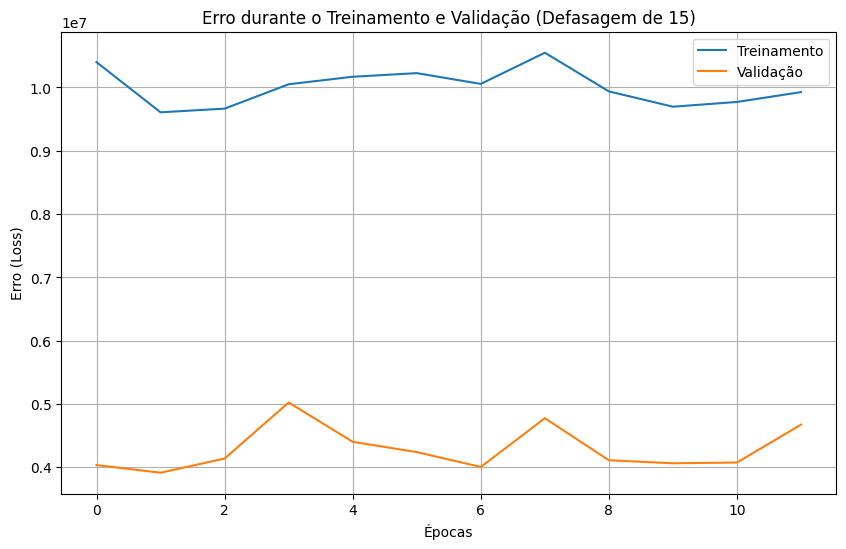


Gráfico de Erro para Modelo com Defasagem de 30:


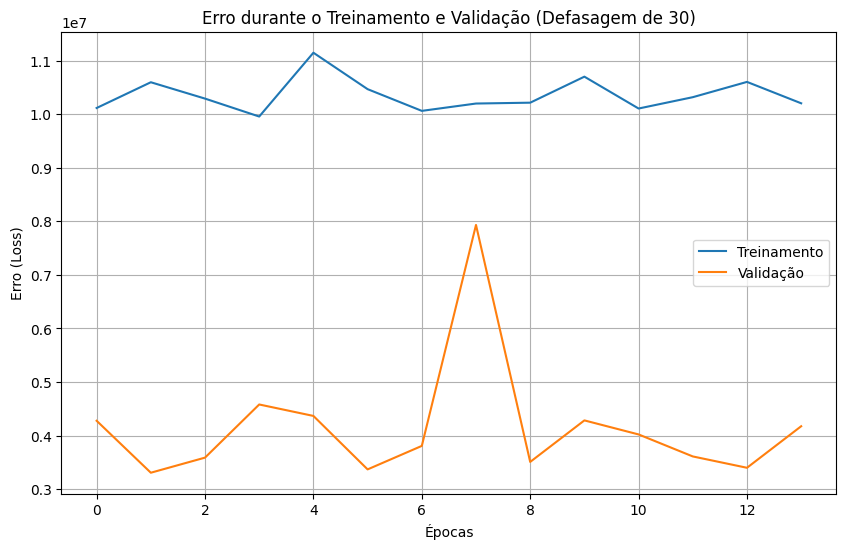


Gráfico de Erro para Modelo com Defasagem de 45:


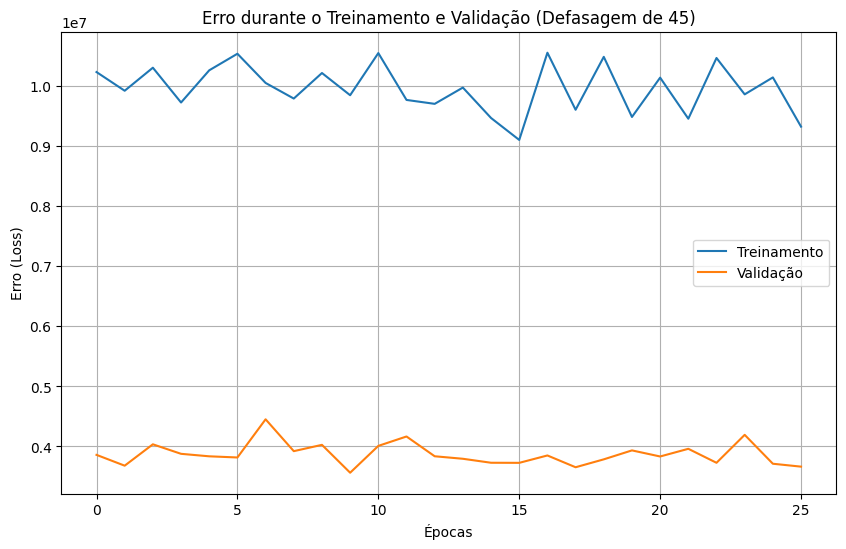


Avaliação no conjunto de validação e teste:

Modelo com defasagem de 15:
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
MSE no conjunto de validação: 3867572.5472757756
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step
MSE no conjunto de teste: 3682074.816904807

Modelo com defasagem de 30:
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
MSE no conjunto de validação: 4433003.269160345
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step
MSE no conjunto de teste: 4473513.059660601

Modelo com defasagem de 45:
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
MSE no conjunto de validação: 3719406.052378829
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step
MSE no conjunto de teste: 3500016.6153142317


In [11]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt
import numpy as np

# Dividir os dados em treino, teste e validação
def dividir_dados(X, y, test_size=0.2, val_size=0.25):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

# Dados com defasagem
X_train_15, X_val_15, X_test_15, y_train_15, y_val_15, y_test_15 = dividir_dados(X_15, y_15)
X_train_30, X_val_30, X_test_30, y_train_30, y_val_30, y_test_30 = dividir_dados(X_30, y_30)
X_train_45, X_val_45, X_test_45, y_train_45, y_val_45, y_test_45 = dividir_dados(X_45, y_45)

# Função para construir o modelo MLP
def criar_modelo(input_dim, output_dim, learning_rate=0.01):
    model = Sequential()
    model.add(InputLayer(shape=(input_dim,)))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(output_dim, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

def build_keras_regressor(input_dim, output_dim, learning_rate=0.01):
    return KerasRegressor(model=lambda: criar_modelo(input_dim, output_dim, learning_rate), epochs=50, batch_size=64, verbose=0)

def avaliar_com_cross_val(X_train, y_train, input_dim):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', build_keras_regressor(input_dim, y_train.shape[1]))
    ])

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1)
    mean_score = -np.mean(scores)
    print(f'Média MSE de validação: {mean_score}')
    
    pipeline.fit(X_train, y_train)
    return pipeline

# Avaliar para diferentes conjuntos de dados
print("Dados com defasagem de 15:")
pipeline_15 = avaliar_com_cross_val(X_train_15, y_train_15, X_train_15.shape[1])

print("\nDados com defasagem de 30:")
pipeline_30 = avaliar_com_cross_val(X_train_30, y_train_30, X_train_30.shape[1])

print("\nDados com defasagem de 45:")
pipeline_45 = avaliar_com_cross_val(X_train_45, y_train_45, X_train_45.shape[1])

def ajustar_pipeline(pipeline, X_train, y_train):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    scaler = pipeline.named_steps['scaler']
    X_train = scaler.fit_transform(X_train)
    
    model = pipeline.named_steps['regressor'].model_
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stopping], validation_split=0.25)
    
    return pipeline, history

# Ajustar os pipelines e obter os históricos
pipeline_15, history_15 = ajustar_pipeline(pipeline_15, X_train_15, y_train_15)
pipeline_30, history_30 = ajustar_pipeline(pipeline_30, X_train_30, y_train_30)
pipeline_45, history_45 = ajustar_pipeline(pipeline_45, X_train_45, y_train_45)

def avaliar_pipeline(pipeline, X_val, y_val, X_test, y_test):
    scaler = pipeline.named_steps['scaler']
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    y_val_pred = pipeline.named_steps['regressor'].model_.predict(X_val)
    val_mse = mean_squared_error(y_val, y_val_pred)
    print(f'MSE no conjunto de validação: {val_mse}')
    
    y_test_pred = pipeline.named_steps['regressor'].model_.predict(X_test)
    test_mse = mean_squared_error(y_test, y_test_pred)
    print(f'MSE no conjunto de teste: {test_mse}')
    
    return val_mse, test_mse

def plot_history(history, title):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Treinamento')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validação')
    plt.title(title)
    plt.xlabel('Épocas')
    plt.ylabel('mse')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotar os gráficos de erro
print("\nGráfico de Erro para Modelo com Defasagem de 15:")
plot_history(history_15, 'Erro durante o Treinamento e Validação (Defasagem de 15)')

print("\nGráfico de Erro para Modelo com Defasagem de 30:")
plot_history(history_30, 'Erro durante o Treinamento e Validação (Defasagem de 30)')

print("\nGráfico de Erro para Modelo com Defasagem de 45:")
plot_history(history_45, 'Erro durante o Treinamento e Validação (Defasagem de 45)')

# Avaliação no conjunto de validação e teste
print("\nAvaliação no conjunto de validação e teste:")

print("\nModelo com defasagem de 15:")
val_mse_15, test_mse_15 = avaliar_pipeline(pipeline_15, X_val_15, y_val_15, X_test_15, y_test_15)

print("\nModelo com defasagem de 30:")
val_mse_30, test_mse_30 = avaliar_pipeline(pipeline_30, X_val_30, y_val_30, X_test_30, y_test_30)

print("\nModelo com defasagem de 45:")
val_mse_45, test_mse_45 = avaliar_pipeline(pipeline_45, X_val_45, y_val_45, X_test_45, y_test_45)


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Dividir dados em treino e teste
X_train_15, X_test_15, y_train_15, y_test_15 = train_test_split(X_15, y_15, test_size=0.3, random_state=42)
X_train_30, X_test_30, y_train_30, y_test_30 = train_test_split(X_30, y_30, test_size=0.3, random_state=42)
X_train_45, X_test_45, y_train_45, y_test_45 = train_test_split(X_45, y_45, test_size=0.3, random_state=42)
# Dividir dados de treino em treino e validação
X_train_15, X_val_15, y_train_15, y_val_15 = train_test_split(X_train_15, y_train_15, test_size=0.2, random_state=42)
X_train_30, X_val_30, y_train_30, y_val_30 = train_test_split(X_train_30, y_train_30, test_size=0.2, random_state=42)
X_train_45, X_val_45, y_train_45, y_val_45 = train_test_split(X_train_45, y_train_45, test_size=0.2, random_state=42)



def treinar_e_avaliar(X_train, y_train, X_val, y_val, input_dim):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_no = 1
    val_scores = []

    for train_index, val_index in kfold.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Normalizar os dados
        scaler = StandardScaler()
        X_train_fold = scaler.fit_transform(X_train_fold)
        X_val_fold = scaler.transform(X_val_fold)
        X_val = scaler.transform(X_val)  # Normalizar dados de validação

        # Construir e treinar o modelo
        model = criar_modelo(input_dim, y_train.shape[1])
        model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0)

        # Avaliar o modelo
        val_mse = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        val_scores.append(val_mse)
        print(f'Fold {fold_no} - MSE: {val_mse}')
        fold_no += 1

    print(f'Média MSE de validação: {np.mean(val_scores)}')
    return model

# Treinar e avaliar para os diferentes conjuntos de dados
print("Dados com defasagem de 15:")
model_15 = treinar_e_avaliar(X_train_15, y_train_15, X_val_15, y_val_15, X_train_15.shape[1])

print("\nDados com defasagem de 30:")
model_30 = treinar_e_avaliar(X_train_30, y_train_30, X_val_30, y_val_30, X_train_30.shape[1])

print("\nDados com defasagem de 45:")
model_45 = treinar_e_avaliar(X_train_45, y_train_45, X_val_45, y_val_45, X_train_45.shape[1])


# Avaliar os modelos nos dados de teste
def avaliar_modelo(model, X_test, y_test):
    # Normalizar os dados de teste
    scaler = StandardScaler()
    X_test = scaler.fit_transform(X_test)

    # Avaliar o modelo
    y_pred = model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    print(f'MSE no conjunto de teste: {test_mse}')
    return test_mse

print("\nAvaliação no conjunto de teste:")

print("\nModelo com defasagem de 15:")
test_mse_15 = avaliar_modelo(model_15, X_test_15, y_test_15)

print("\nModelo com defasagem de 30:")
test_mse_30 = avaliar_modelo(model_30, X_test_30, y_test_30)

print("\nModelo com defasagem de 45:")
test_mse_45 = avaliar_modelo(model_45, X_test_45, y_test_45)


Dados com defasagem de 15:
Fold 1 - MSE: 4592052.0
Fold 2 - MSE: 4392229.0
Fold 3 - MSE: 3767979.25
Fold 4 - MSE: 5159428.0
Fold 5 - MSE: 3584693.25
Média MSE de validação: 4299276.3

Dados com defasagem de 30:
Fold 1 - MSE: 4146178.0
Fold 2 - MSE: 4336626.5
Fold 3 - MSE: 3817454.75
Fold 4 - MSE: 3594675.25
Fold 5 - MSE: 3747398.75
Média MSE de validação: 3928466.65

Dados com defasagem de 45:
Fold 1 - MSE: 3585497.75
Fold 2 - MSE: 3392064.0
Fold 3 - MSE: 3714895.0
Fold 4 - MSE: 3778752.5
Fold 5 - MSE: 3393062.5
Média MSE de validação: 3572854.35

Avaliação no conjunto de teste:

Modelo com defasagem de 15:
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
MSE no conjunto de teste: 3877321.519625435

Modelo com defasagem de 30:
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
MSE no conjunto de teste: 3700010.4761337643

Modelo com defasagem de 45:
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
MSE no conjunto de teste: 3705125.804012568
